In [1]:
import numpy as np 
import math
import pandas as pd
import random as rd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [2]:
exps_dir = "../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature1"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

In [3]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
x_train

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,...,auto_year,day_policy_bind_date,month_policy_bind_date,year_policy_bind_date,day_incident_date,month_incident_date,year_incident_date,week_incident_date,high_week,high_hour
0,2,0,0,1,1,-1.770734,0,1,2,11,...,2,0.579574,-0.179439,-1.020460,-1.393943,-0.947412,0,-1.705084,0,0
1,0,2,1,0,2,-1.979562,0,1,4,11,...,0,-0.547936,-0.179439,0.908584,0.115223,0.953085,0,1.136723,0,0
2,2,0,2,0,2,0.675544,0,0,0,5,...,1,1.481582,0.108179,-0.744883,0.115223,-0.947412,0,-0.893139,1,0
3,2,0,0,0,2,-0.492901,0,0,2,2,...,0,1.368831,-0.467057,1.735317,-1.626123,2.853582,0,1.542695,0,0
4,2,0,2,1,1,0.613672,0,1,4,2,...,1,0.128570,0.971032,1.735317,1.160031,-0.947412,0,-0.487167,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,2,0,2,0,2,-1.393488,0,0,0,6,...,1,0.908354,0.656524,0.393463,-0.917630,-0.947412,0,-1.409131,0,0
1018,1,0,0,0,0,0.661055,0,0,1,3,...,0,0.839585,-0.592273,1.479683,0.680663,0.953085,0,1.071228,0,0
1019,0,0,1,0,1,-0.077354,5,1,4,3,...,1,-0.883912,-0.196871,-1.006542,-0.093503,0.914690,0,0.706145,1,1
1020,0,0,1,0,0,-0.839075,3,0,5,5,...,1,0.355841,-0.752419,0.704873,0.118865,0.953085,0,0.936124,0,0


In [4]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(1022, 42) (1022, 1) (330, 42) (330, 1)


In [5]:
# -*- coding: utf-8 -*-
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Flatten
from keras.models import Model
from keras.layers import Input

def VGG16():
    # Determine proper input shape
    input_shape =(42,1)
    x_input = Input(shape=input_shape)

    # Block 1
    x = Conv1D(64, 3, activation='relu', padding='same', name='block1_conv1')(x_input)
    x = Conv1D(64, 3, activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling1D(2, strides=2, name='block1_pool')(x)

    # Block 2
    x = Conv1D(128, 3, activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv1D(128, 3, activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling1D(2, strides=2, name='block2_pool')(x)

    # Block 3
    x = Conv1D(256, 3, activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv1D(256, 3, activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv1D(256, 3, activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling1D(2, strides=2, name='block3_pool')(x)

    # Block 4
    x = Conv1D(512, 3, activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv1D(512, 3, activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv1D(512, 3, activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling1D(2, strides=2, name='block4_pool')(x)

    # Block 5
    x = Conv1D(512, 3, activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv1D(512, 3, activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv1D(512, 3, activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling1D(2, strides=2, name='block5_pool')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(1, activation='sigmoid', name='predictions')(x)  # Sigmoid for binary classification

    #x = GlobalAveragePooling1D()(x)
    #x = GlobalMaxPooling1D()(x)
    #x = Dense(classes, activation='sigmoid', name='predictions')(x)  # Sigmoid for binary classification

    # Create model.
    model = Model(x_input, x, name='vgg16')
    return model
model = VGG16()
lr=0.0001
model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 42, 1)]           0         
                                                                 
 block1_conv1 (Conv1D)       (None, 42, 64)            256       
                                                                 
 block1_conv2 (Conv1D)       (None, 42, 64)            12352     
                                                                 
 block1_pool (MaxPooling1D)  (None, 21, 64)            0         
                                                                 
 block2_conv1 (Conv1D)       (None, 21, 128)           24704     
                                                                 
 block2_conv2 (Conv1D)       (None, 21, 128)           49280     
                                                                 
 block2_pool (MaxPooling1D)  (None, 10, 128)           0     

C:\Users\PC\miniconda3\envs\test\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [6]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 30)

early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=30,
    min_lr=0.000001,
    verbose=1,
)
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix

class ConfusionMatrixCallback(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.relist={}
        self.acc=[]

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val)
        y_pred_binary = (y_pred > 0.5).astype(int)

        cm = confusion_matrix(y_val, y_pred_binary)
        print(f"Confusion Matrix after Epoch {epoch + 1}:\n{cm}")
        print(classification_report(y_test,y_pred_binary))
        acc = float(classification_report(y_test,y_pred_binary).split('\n')[3].split()[2])
        self.acc.append(acc)
        self.relist[acc]=y_pred_binary

# ... Định nghĩa mô hình ...

# Tạo đối tượng callback
confusion_matrix_callback = ConfusionMatrixCallback(validation_data=(x_test,y_test))

callbacks = [early_stopping,lr_scheduler]

checkpointer = ModelCheckpoint(filepath = "Emotion_weights.hdf5", verbose = 1, save_best_only=True)

history=model.fit(x=x_train,y=y_train,
          validation_data=(x_test,y_test),
          batch_size=64,epochs=120, callbacks=[earlystopping,checkpointer])


Epoch 1/120
16/16 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.4824
Epoch 1: val_loss improved from inf to 0.69257, saving model to Emotion_weights.hdf5
16/16 [==============================] - 11s 669ms/step - loss: 0.6936 - accuracy: 0.4824 - val_loss: 0.6926 - val_accuracy: 0.6545
Epoch 2/120
16/16 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.5098
Epoch 2: val_loss improved from 0.69257 to 0.65875, saving model to Emotion_weights.hdf5
16/16 [==============================] - 2s 153ms/step - loss: 0.6909 - accuracy: 0.5098 - val_loss: 0.6587 - val_accuracy: 0.7333
Epoch 3/120
16/16 [==============================] - ETA: 0s - loss: 0.6656 - accuracy: 0.5959
Epoch 3: val_loss improved from 0.65875 to 0.59365, saving model to Emotion_weights.hdf5
16/16 [==============================] - 2s 157ms/step - loss: 0.6656 - accuracy: 0.5959 - val_loss: 0.5936 - val_accuracy: 0.6636
Epoch 4/120
16/16 [==============================] - ETA: 

16/16 [==============================] - ETA: 0s - loss: 5.7865e-05 - accuracy: 1.0000
Epoch 30: val_loss did not improve from 0.59365
16/16 [==============================] - 2s 100ms/step - loss: 5.7865e-05 - accuracy: 1.0000 - val_loss: 2.2288 - val_accuracy: 0.7121
Epoch 31/120
16/16 [==============================] - ETA: 0s - loss: 4.6101e-05 - accuracy: 1.0000
Epoch 31: val_loss did not improve from 0.59365
16/16 [==============================] - 2s 99ms/step - loss: 4.6101e-05 - accuracy: 1.0000 - val_loss: 2.2782 - val_accuracy: 0.7121
Epoch 32/120
16/16 [==============================] - ETA: 0s - loss: 3.8166e-05 - accuracy: 1.0000
Epoch 32: val_loss did not improve from 0.59365
16/16 [==============================] - 2s 104ms/step - loss: 3.8166e-05 - accuracy: 1.0000 - val_loss: 2.3254 - val_accuracy: 0.7091
Epoch 33/120
16/16 [==============================] - ETA: 0s - loss: 3.1934e-05 - accuracy: 1.0000
Epoch 33: val_loss did not improve from 0.59365
16/16 [==========

<Axes: >

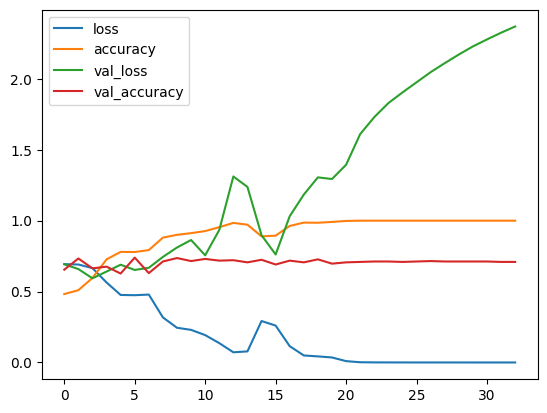

In [7]:
losses = pd.DataFrame(history.history)
losses.plot()

In [8]:
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)
print(classification_report(y_test,y_pred_binary))


11/11 [==============================] - 1s 19ms/step
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       242
           1       0.45      0.43      0.44        88

    accuracy                           0.71       330
   macro avg       0.62      0.62      0.62       330
weighted avg       0.70      0.71      0.71       330



In [9]:
print(y_pred_binary)

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
